Goal: Predict total number of citibike rides each day, based on variables such as year,month,day of week, temperature. etc.

Steps:
- Will do for one year to start, then extend
- Get total # rides grouped by day
- Get daily temperatures
- Separate into predictors/target
- Train/test split
- Fit linear regression, Ridge, Lasso models and evaluate performance.

In [1]:
# import libraries and connect to database
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
con = sqlite3.connect("data/citibike_database.db3")

In [2]:
# Get total number of rides each day
year = 2015
query = "SELECT yday,wkday,count(*) as N FROM rides WHERE year=? GROUP BY yday"
df = pd.read_sql_query(query,con,params=[year])
df.head()

,yday,wkday,N
0,1,3,5317
1,2,4,11304
2,3,5,4478
3,4,6,7849
4,5,0,14506


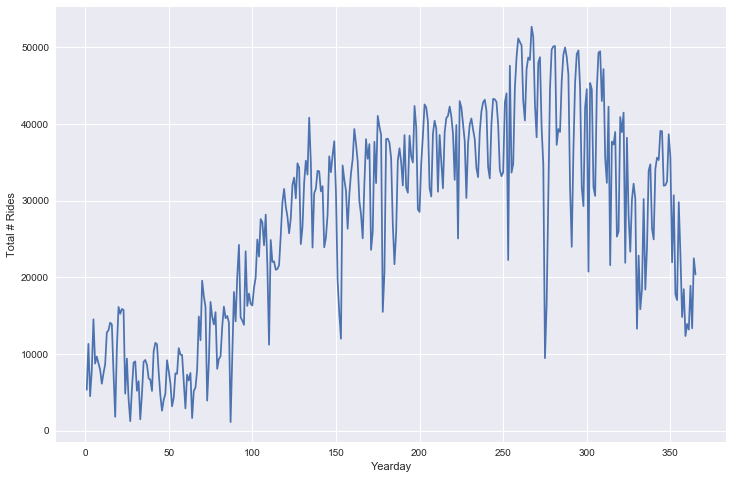

In [3]:
plt.figure(figsize=(12,8))
plt.plot(df.yday, df.N);
plt.xlabel('Yearday')
plt.ylabel('Total # Rides');

In [4]:
# get number of distinct stations each day
query = "SELECT yday,count(distinct start_station_id) as N_sta FROM rides WHERE year=? GROUP BY yday"
df_sta = pd.read_sql_query(query,con,params=[year])
df_sta.head()

,yday,N_sta
0,1,327
1,2,327
2,3,323
3,4,329
4,5,330


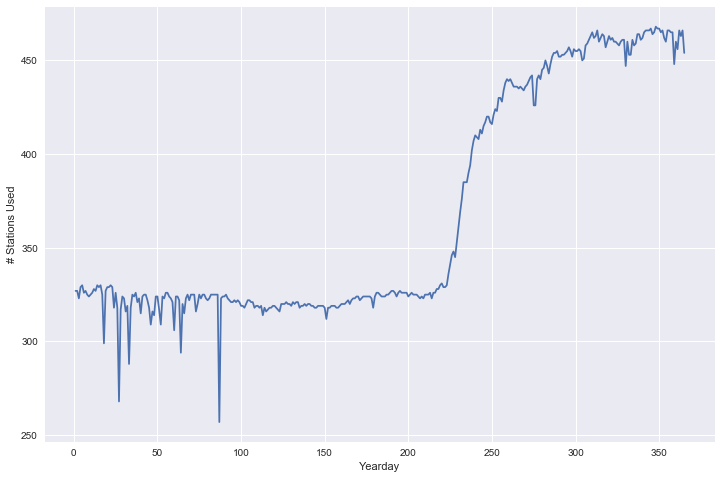

In [5]:
# Plot # stations vs yday (only counts tations that were used that day, so not necessarily
# all stations in service)
# NOTE spikes are likely days where not many rides taken
plt.figure(figsize=(12,8))
plt.plot(df_sta.yday, df_sta.N_sta);
plt.xlabel('Yearday')
plt.ylabel('# Stations Used');

In [6]:
# Get mean temperature for each day
con2 = sqlite3.connect('data/nyc_weather.db3')
query2 = "SELECT yday,Mean_TemperatureF as Tmean FROM temps WHERE year=?"
df2 = pd.read_sql_query(query2, con2, params=[year])
df2.head()

,yday,Tmean
0,1,33
1,2,39
2,3,36
3,4,49
4,5,36


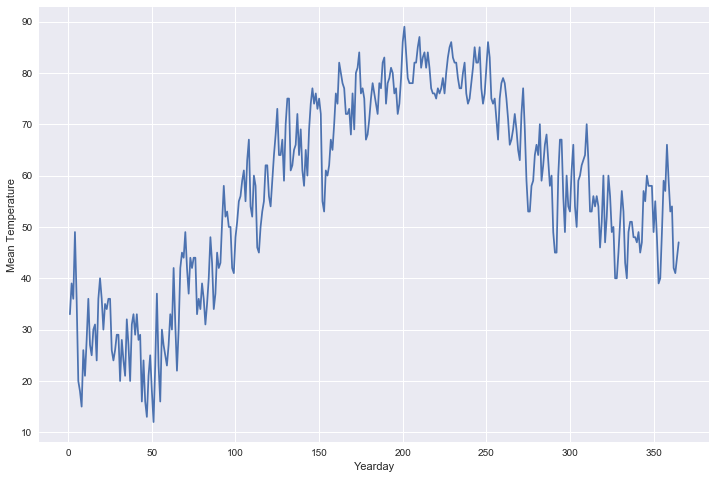

In [7]:
plt.figure(figsize=(12,8))
plt.plot(df2.yday, df2.Tmean);
plt.xlabel('Yearday')
plt.ylabel('Mean Temperature');

In [8]:
# join temps to rides data frame
df_comb = pd.merge(df,df2,left_on='yday',right_on='yday')
df_comb = pd.merge(df_comb, df_sta, left_on='yday',right_on='yday')
df_comb.head()

,yday,wkday,N,Tmean,N_sta
0,1,3,5317,33,327
1,2,4,11304,39,327
2,3,5,4478,36,323
3,4,6,7849,49,329
4,5,0,14506,36,330


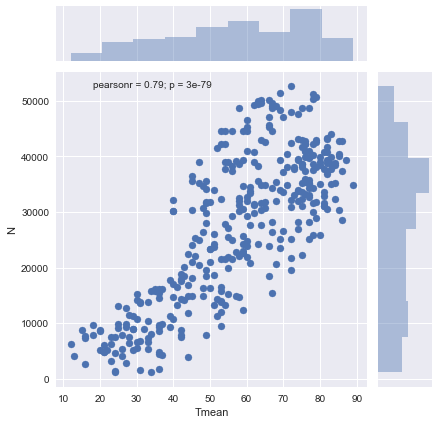

In [9]:
sns.jointplot(df_comb.Tmean,df_comb.N);

The daily # rides is positively correlated with daily temperature, but there is a lot of unexplained scatter.

In [10]:
# create dummy variables for wkday
# NOTE drop_first drops redundant column from dummy vars
df_comb = pd.get_dummies(data=df_comb, columns=['wkday'],drop_first=True)
df_comb.head()

,yday,N,Tmean,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6
0,1,5317,33,327,0,0,1,0,0,0
1,2,11304,39,327,0,0,0,1,0,0
2,3,4478,36,323,0,0,0,0,1,0
3,4,7849,49,329,0,0,0,0,0,1
4,5,14506,36,330,0,0,0,0,0,0


In [11]:
df_comb.head()

,yday,N,Tmean,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6
0,1,5317,33,327,0,0,1,0,0,0
1,2,11304,39,327,0,0,0,1,0,0
2,3,4478,36,323,0,0,0,0,1,0
3,4,7849,49,329,0,0,0,0,0,1
4,5,14506,36,330,0,0,0,0,0,0


In [12]:
# split data into predictor/target arrays in prep for modelling
X = df_comb.drop('N', axis=1)
X.head()

,yday,Tmean,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6
0,1,33,327,0,0,1,0,0,0
1,2,39,327,0,0,0,1,0,0
2,3,36,323,0,0,0,0,1,0
3,4,49,329,0,0,0,0,0,1
4,5,36,330,0,0,0,0,0,0


In [13]:
y = df_comb['N']
y.head()

0     5317
1    11304
2     4478
3     7849
4    14506
Name: N, dtype: int64

## Split data into training/test sets

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.3, random_state=39)

## Linear Regression

In [15]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train,y_train)
preds = reg.predict(X_test)


In [16]:
# score on training set
reg.score(X_train,y_train)

0.80217057725500129

In [17]:
# score on test set
reg.score(X_test,y_test)

0.78507776866384393

In [18]:
# cross-val score gives a better estimate of how the model will perform on new data
from sklearn.model_selection import cross_val_score
cross_val_score(reg,X_train,y_train)

array([ 0.79083255,  0.75221092,  0.80746069])

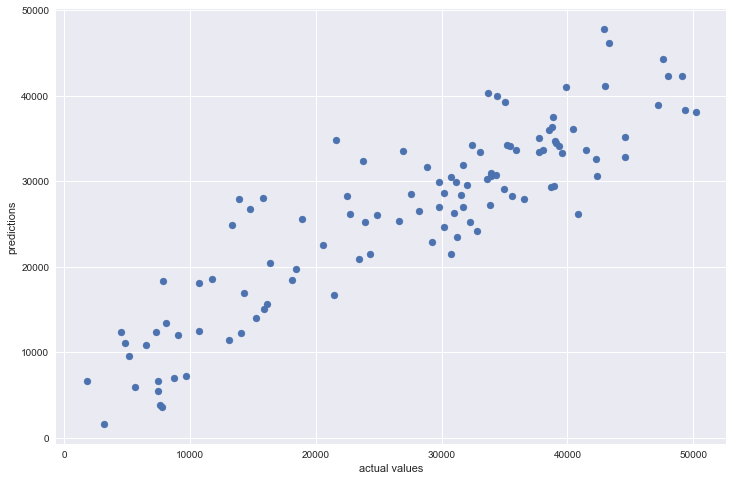

In [19]:
# plot predictions vs actual values
plt.figure(figsize=(12,8))
plt.scatter(y_test,preds)
plt.xlabel('actual values')
plt.ylabel('predictions');

In [20]:
# Examine coefficients
coefs = pd.DataFrame({'vars':X.columns,'coef':reg.coef_})
coefs.sort_values('coef')

,coef,vars
8,-5744.530973,wkday_6
7,-3354.750131,wkday_5
5,-383.181415,wkday_3
0,-31.027043,yday
2,122.290096,N_sta
3,305.024804,wkday_1
1,582.130140,Tmean
6,1143.904344,wkday_4
4,1540.496111,wkday_2


## Next i'll try some linear regression models w/ regularization, which shoud reduce overfitting.

### Ridge Regression
Ridge regression can shrink the coefficients close to, but not exactly zero.

In [21]:
from sklearn.linear_model import Ridge
rid = Ridge()
rid.fit(X_train,y_train)
preds = rid.predict(X_test)
rid.score(X_train,y_train)

0.80212838468132075

In [22]:
rid.score(X_test,y_test)

0.78433452347613475

In [23]:
coefs = pd.DataFrame({'vars':X.columns,'coef':rid.coef_})
coefs.sort_values('coef')

,coef,vars
8,-5451.080863,wkday_6
7,-3102.883241,wkday_5
5,-222.060483,wkday_3
0,-31.328257,yday
2,122.682437,N_sta
3,445.795234,wkday_1
1,583.070531,Tmean
6,1265.007015,wkday_4
4,1650.003402,wkday_2


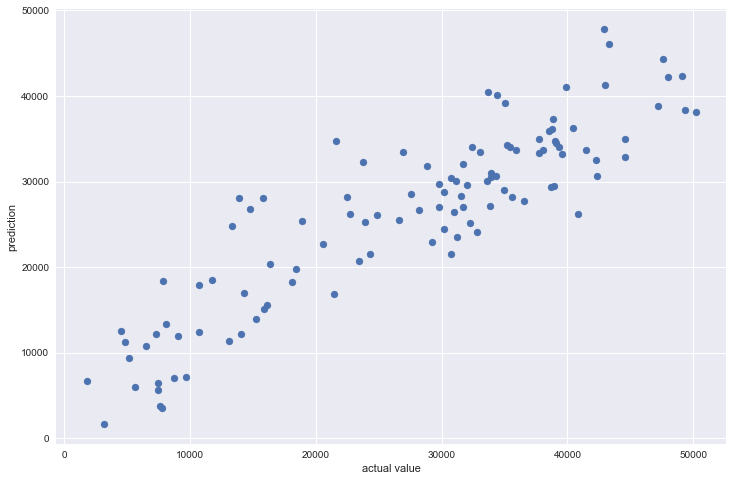

In [24]:
plt.figure(figsize=(12,8))
plt.scatter(y_test,preds)
plt.xlabel('actual value')
plt.ylabel('prediction');

In [25]:
cross_val_score(rid,X_train,y_train)

array([ 0.79040137,  0.75343202,  0.80756937])

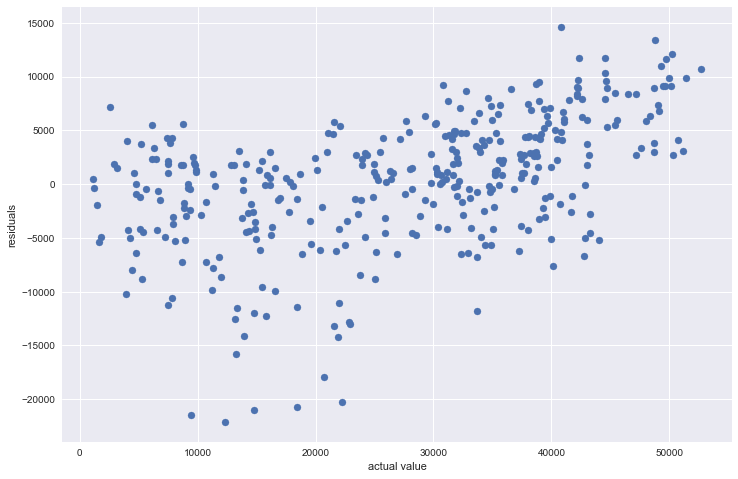

In [26]:
# look at residuals
plt.figure(figsize=(12,8))
preds = rid.predict(X)
resids = y-preds
plt.scatter(y,resids);
plt.xlabel('actual value')
plt.ylabel('residuals');
# looks like error/residual is corellated with y value
# model overestimates low values, and overestimates larger values??

Ridge model has parameter *alpha* we can tune, which controls the strength of the regularization; use GridSearchCV to try to optimize:

In [27]:
from sklearn.model_selection import GridSearchCV
rid = Ridge()
params = {'alpha':[0.1, 0.5, 1,2,5, 100]}
cv_rid = GridSearchCV(rid,params)
cv_rid.fit(X_train,y_train)
cv_rid.best_params_

{'alpha': 2}

In [28]:
cv_rid.best_score_

0.78387798212500714

In [29]:
# score on test set
cv_rid.score(X_test,y_test)

0.78359956503721984

### Lasso
In Lasso, some of the coefficients can actually be set to zero.

In [30]:
# try lasso
from sklearn.linear_model import Lasso
las = Lasso(max_iter=4000)
params = {'alpha':[0.1, 0.5, 1,2,10, 100]}
cv_las = GridSearchCV(las,params)
cv_las.fit(X_train,y_train)
cv_las.best_params_
#cv_las.best_score_

{'alpha': 10}

In [31]:
cv_las.score(X_test,y_test)

0.78516540842275995

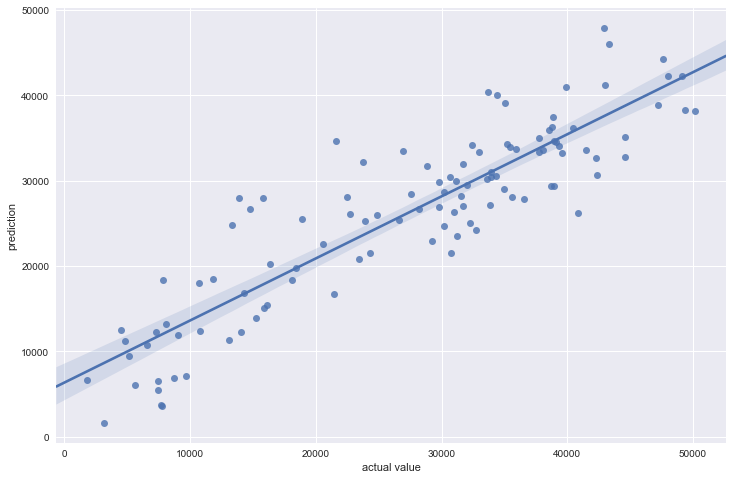

In [32]:
plt.figure(figsize=(12,8))
#plt.scatter(y_test,cv_las.predict(X_test));
sns.regplot(y_test,cv_las.predict(X_test));
plt.xlabel('actual value')
plt.ylabel('prediction')

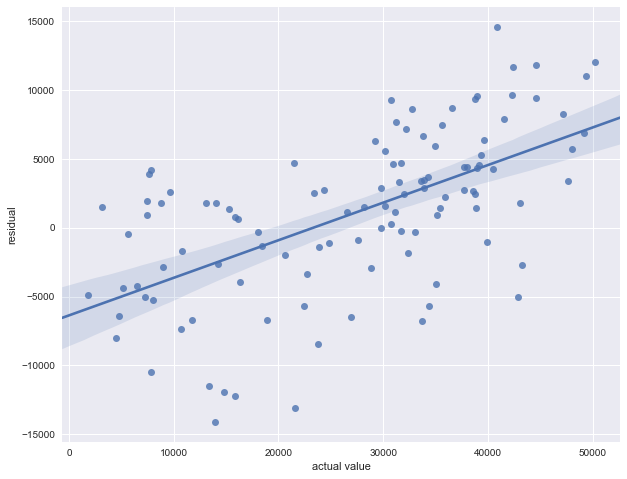

In [33]:
plt.figure(figsize=(10,8))
#plt.scatter(y_test,y_test-cv_las.predict(X_test));
sns.regplot(y_test,y_test-cv_las.predict(X_test));
plt.xlabel('actual value')
plt.ylabel('residual')

In [34]:
# compare test-set scores of all3
print('LinReg test score: ' + str(reg.score(X_test,y_test)))
print('ridge test score: ' + str(cv_rid.score(X_test,y_test)))
print('Lasso test score: ' + str(cv_las.score(X_test,y_test)))


LinReg test score: 0.785077768664
ridge test score: 0.783599565037
Lasso test score: 0.785165408423


In this case, Ridge and Lasso don't give much of an imporvement over simple linear regression. All 3 models get a R^2 score of about 0.78-0.79 on the test data.

### Where is the model not doing well?
- Next i'll try to look at where the model is not doing well and see what is different about those days.

- Try using weekday/weekend as a variable w/ 2 categories?
- Try adding holidays?

In [35]:
X2 = X.copy()
X2['resid'] = y - reg.predict(X)
X2.head(10)

,yday,Tmean,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,resid
0,1,33,327,0,0,1,0,0,0,-8836.106072
1,2,39,327,0,0,0,1,0,0,-7837.945630
2,3,36,323,0,0,0,0,1,0,-7898.713307
3,4,49,329,0,0,0,0,0,1,-10408.337821
4,5,36,330,0,0,0,0,0,0,-2019.440023
5,6,20,326,1,0,0,0,0,0,1742.804844
6,7,18,327,0,1,0,0,0,0,2487.330765
7,8,15,325,0,0,1,0,0,0,5566.005948
8,9,26,324,0,0,0,1,0,0,-3060.194215
9,10,21,325,0,0,0,0,1,0,2436.847909


In [36]:
X2.sort_values('resid').head(10)

,yday,Tmean,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,resid
358,359,59,448,0,0,0,1,0,0,-22171.995573
274,275,53,426,0,0,0,1,0,0,-21484.104260
356,357,57,465,0,1,0,0,0,0,-21061.312776
357,358,66,465,0,0,1,0,0,0,-20715.779469
252,253,75,423,0,0,1,0,0,0,-20270.606253
300,301,61,455,0,1,0,0,0,0,-17985.446804
329,330,51,447,0,0,1,0,0,0,-15807.362852
322,323,60,460,0,0,1,0,0,0,-14254.494664
359,360,53,460,0,0,0,0,1,0,-14036.014363
313,314,56,460,1,0,0,0,0,0,-13198.423712


In [37]:
# get dates for these
query ='SELECT distinct year,month,day,yday FROM rides WHERE year=2015'
df_dates = pd.read_sql_query(query,con)
df_dates.head()

,year,month,day,yday
0,2015,1,1,1
1,2015,1,2,2
2,2015,1,3,3
3,2015,1,4,4
4,2015,1,5,5


In [38]:
df_dates.shape

(365, 4)

In [39]:
X2=X2.merge(df_dates,left_on='yday',right_on='yday')
X2.shape

(365, 13)

In [40]:
X2.head()

,yday,Tmean,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,resid,year,month,day
0,1,33,327,0,0,1,0,0,0,-8836.106072,2015,1,1
1,2,39,327,0,0,0,1,0,0,-7837.945630,2015,1,2
2,3,36,323,0,0,0,0,1,0,-7898.713307,2015,1,3
3,4,49,329,0,0,0,0,0,1,-10408.337821,2015,1,4
4,5,36,330,0,0,0,0,0,0,-2019.440023,2015,1,5


In [41]:
# where model overpredicts (resid is negative)
X2.sort_values('resid').head(10)

,yday,Tmean,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,resid,year,month,day
358,359,59,448,0,0,0,1,0,0,-22171.995573,2015,12,25
274,275,53,426,0,0,0,1,0,0,-21484.104260,2015,10,2
356,357,57,465,0,1,0,0,0,0,-21061.312776,2015,12,23
357,358,66,465,0,0,1,0,0,0,-20715.779469,2015,12,24
252,253,75,423,0,0,1,0,0,0,-20270.606253,2015,9,10
300,301,61,455,0,1,0,0,0,0,-17985.446804,2015,10,28
329,330,51,447,0,0,1,0,0,0,-15807.362852,2015,11,26
322,323,60,460,0,0,1,0,0,0,-14254.494664,2015,11,19
359,360,53,460,0,0,0,0,1,0,-14036.014363,2015,12,26
313,314,56,460,1,0,0,0,0,0,-13198.423712,2015,11,10


Ok some of these make sense. I see days before Xmas, Halloween, Thanksgiving, etc.. I'll get list of holidays next and add these to the model.

In [42]:
query = "SELECT * FROM holidays WHERE public=1"
df_holi = pd.read_sql_query(query,con)
df_holi

,date,name,observed,public,yday,year
0,2015-01-01 00:00:00,New Year's Day,2015-01-01 00:00:00,1,1,2015
1,2015-01-19 00:00:00,"Martin Luther King, Jr. Day",2015-01-19 00:00:00,1,19,2015
2,2015-02-16 00:00:00,George Washington's Birthday,2015-02-16 00:00:00,1,47,2015
3,2015-05-25 00:00:00,Memorial Day,2015-05-25 00:00:00,1,145,2015
4,2015-07-04 00:00:00,Independence Day,2015-07-03 00:00:00,1,184,2015
5,2015-09-07 00:00:00,Labor Day,2015-09-07 00:00:00,1,250,2015
6,2015-10-12 00:00:00,Columbus Day,2015-10-12 00:00:00,1,285,2015
7,2015-11-11 00:00:00,Veterans Day,2015-11-11 00:00:00,1,315,2015
8,2015-11-26 00:00:00,Thanksgiving Day,2015-11-26 00:00:00,1,330,2015
9,2015-12-25 00:00:00,Christmas Day,2015-12-25 00:00:00,1,359,2015


In [43]:
# merge this with other data
X2 = X2.merge(df_holi,left_on='yday',right_on='yday',how='left')
X2.head()

,yday,Tmean,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,resid,year_x,month,day,date,name,observed,public,year_y
0,1,33,327,0,0,1,0,0,0,-8836.106072,2015,1,1,2015-01-01 00:00:00,New Year's Day,2015-01-01 00:00:00,1.0,2015.0
1,2,39,327,0,0,0,1,0,0,-7837.945630,2015,1,2,NaN,NaN,NaN,NaN,NaN
2,3,36,323,0,0,0,0,1,0,-7898.713307,2015,1,3,NaN,NaN,NaN,NaN,NaN
3,4,49,329,0,0,0,0,0,1,-10408.337821,2015,1,4,NaN,NaN,NaN,NaN,NaN
4,5,36,330,0,0,0,0,0,0,-2019.440023,2015,1,5,NaN,NaN,NaN,NaN,NaN


In [44]:
X2.public.fillna(0,inplace=True)
X2.head()

,yday,Tmean,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,resid,year_x,month,day,date,name,observed,public,year_y
0,1,33,327,0,0,1,0,0,0,-8836.106072,2015,1,1,2015-01-01 00:00:00,New Year's Day,2015-01-01 00:00:00,1.0,2015.0
1,2,39,327,0,0,0,1,0,0,-7837.945630,2015,1,2,NaN,NaN,NaN,0.0,NaN
2,3,36,323,0,0,0,0,1,0,-7898.713307,2015,1,3,NaN,NaN,NaN,0.0,NaN
3,4,49,329,0,0,0,0,0,1,-10408.337821,2015,1,4,NaN,NaN,NaN,0.0,NaN
4,5,36,330,0,0,0,0,0,0,-2019.440023,2015,1,5,NaN,NaN,NaN,0.0,NaN


In [45]:
X2.sort_values('resid').head(10)

,yday,Tmean,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,resid,year_x,month,day,date,name,observed,public,year_y
358,359,59,448,0,0,0,1,0,0,-22171.995573,2015,12,25,2015-12-25 00:00:00,Christmas Day,2015-12-25 00:00:00,1.0,2015.0
274,275,53,426,0,0,0,1,0,0,-21484.104260,2015,10,2,NaN,NaN,NaN,0.0,NaN
356,357,57,465,0,1,0,0,0,0,-21061.312776,2015,12,23,NaN,NaN,NaN,0.0,NaN
357,358,66,465,0,0,1,0,0,0,-20715.779469,2015,12,24,NaN,NaN,NaN,0.0,NaN
252,253,75,423,0,0,1,0,0,0,-20270.606253,2015,9,10,NaN,NaN,NaN,0.0,NaN
300,301,61,455,0,1,0,0,0,0,-17985.446804,2015,10,28,NaN,NaN,NaN,0.0,NaN
329,330,51,447,0,0,1,0,0,0,-15807.362852,2015,11,26,2015-11-26 00:00:00,Thanksgiving Day,2015-11-26 00:00:00,1.0,2015.0
322,323,60,460,0,0,1,0,0,0,-14254.494664,2015,11,19,NaN,NaN,NaN,0.0,NaN
359,360,53,460,0,0,0,0,1,0,-14036.014363,2015,12,26,NaN,NaN,NaN,0.0,NaN
313,314,56,460,1,0,0,0,0,0,-13198.423712,2015,11,10,NaN,NaN,NaN,0.0,NaN


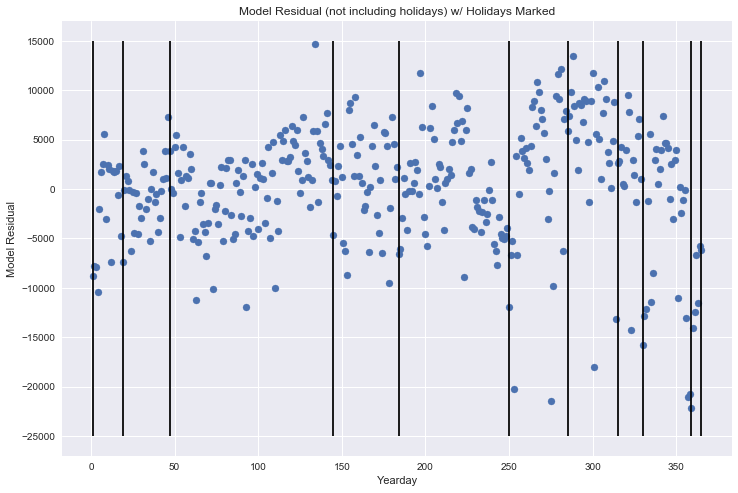

In [46]:
plt.figure(figsize=(12,8))
plt.scatter(X2.yday,X2.resid)
plt.vlines(df_holi.yday,-25000,15000)
plt.xlabel('Yearday')
plt.ylabel('Model Residual')
plt.title('Model Residual (not including holidays) w/ Holidays Marked')

It is obvious that some of the larger residuals are related to holidays. However, they don't always fall on exactly the observed day; many are a day or 2 before/after the actual holiday.

### Try Adding Holiday to Linear Regression Model

In [64]:
X2.drop(['month','day','date','year_x','name','observed','year_y','resid'],axis=1,inplace=True)
#X2.drop('resid',inplace=True,axis=1)
#X2.drop('yday',axis=1,inplace=True)
X2.head()

,Tmean,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6,public
0,33,327,0,0,1,0,0,0,1.0
1,39,327,0,0,0,1,0,0,0.0
2,36,323,0,0,0,0,1,0,0.0
3,49,329,0,0,0,0,0,1,0.0
4,36,330,0,0,0,0,0,0,0.0


In [65]:
# split into training/testing again, using X2 this time
X_train, X_test, y_train, y_test = train_test_split(X2,y,test_size= 0.3, random_state=39)

In [66]:
reg2 = LinearRegression()
reg2.fit(X_train,y_train)
cross_val_score(reg2,X_train,y_train)
reg2.score(X_test,y_test)

0.79416437090665282

In [67]:
coefs = pd.DataFrame({'vars':X_train.columns,'coef':reg2.coef_})
coefs.sort_values('coef')

,coef,vars
8,-8716.837288,public
7,-6968.993877,wkday_6
6,-4794.965119,wkday_5
4,-736.806686,wkday_3
2,-663.164135,wkday_1
1,82.777736,N_sta
5,365.241277,wkday_4
0,509.889382,Tmean
3,576.129803,wkday_2


In [68]:
rid2 = Ridge()
params = {'alpha':[0.1, 0.5, 1,2,5, 100]}
cv_rid2=GridSearchCV(rid2,params)
cv_rid2.fit(X_train,y_train)
cv_rid2.score(X_test,y_test)

0.79455987119752558

In [69]:
from sklearn.ensemble import RandomForestRegressor

In [70]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
rf.score(X_test,y_test)

0.78858461794964185

In [71]:
feat = pd.DataFrame({'imp':rf.feature_importances_,'feat':X_train.columns})
feat.sort_values('imp',ascending=False)

,feat,imp
0,Tmean,0.738198
1,N_sta,0.189498
7,wkday_6,0.022263
4,wkday_3,0.009706
8,public,0.009337
5,wkday_4,0.008637
6,wkday_5,0.008504
3,wkday_2,0.007956
2,wkday_1,0.005902


AttributeError: 'DataFrame' object has no attribute 'yday'

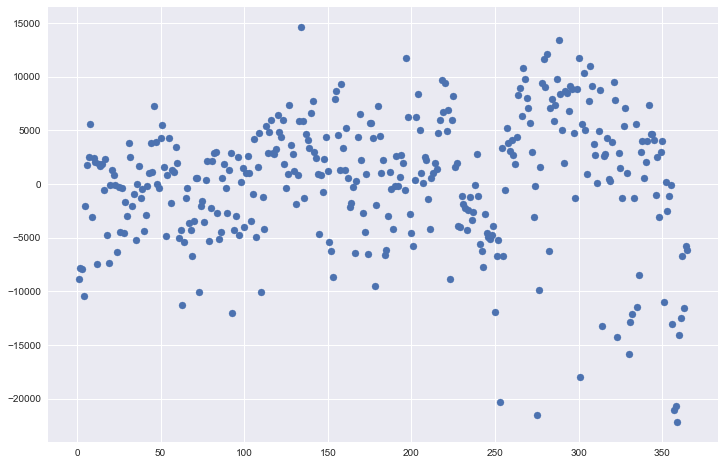

In [72]:
plt.figure(figsize=(12,8))
plt.scatter(X.yday,y-reg.predict(X),label='w/o holidays')
plt.scatter(X2.yday,y-reg2.predict(X2),label='w/ holiday')
plt.legend();
plt.title('model residuals');

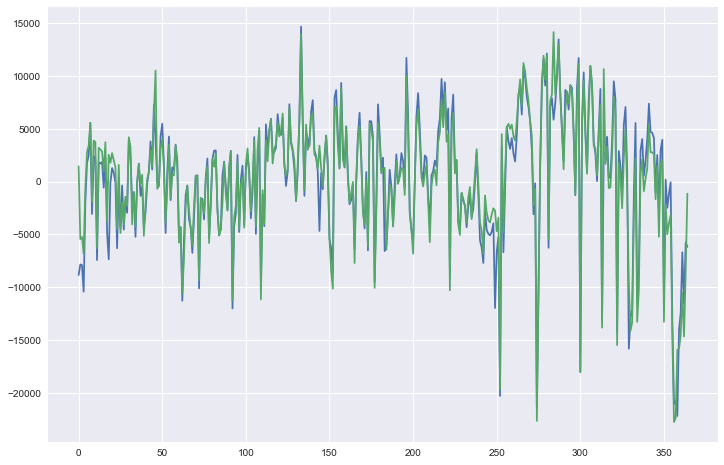

In [77]:
plt.figure(figsize=(12,8))
plt.plot(y-reg.predict(X))
plt.plot(y-reg2.predict(X2))

Adding holidays didn't seem to do too much. But a lot of hte high residuals ocurred a day or two before/after the acutal holiday. Maybe add a 'near holiday' variable also?